# Air temperature Karlskrona
## Import necessary libraries and read the csv file

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import shapiro, anderson
import math
from statistics import mean
df = pd.read_csv("SMHI_Data.csv")
df

,Datum,Tid (UTC),Lufttemperatur
0,2010-03-01,00:00:00,2.0
1,2010-03-01,01:00:00,NaN
2,2010-03-01,02:00:00,2.2
3,2010-03-01,03:00:00,1.7
4,2010-03-01,04:00:00,1.7
...,...,...,...
113976,2023-01-01,02:00:00,6.2
113977,2023-01-01,03:00:00,6.5
113978,2023-01-01,04:00:00,7.7
113979,2023-01-01,05:00:00,8.7


## Data cleaning process
The steps we will take in order to clean the data.

### Missing values
Approximately 6% of the air temperature values are missing which is quite a lot in our opinion but not so many that it is impossible to clean the data and draw meaningful conclusions

In [41]:
null_values = df["Lufttemperatur"].isnull().sum()
df_length = len(df)

print(f"Missing values: {null_values}, Total values: {df_length}, Percentage missing: {(null_values / df_length) * 100}%")

Missing values: 6713, Total values: 113981, Percentage missing: 5.889578087575999%


Replace NAN values with the average of the two not NAN neighbouring values with equal distance to the subject value.

In [87]:
df["Cleaned"] = 0.0

def find_value(df, index):
    j = 0
    backward = df.at[index - j, "Lufttemperatur"]
    forward = df.at[index + j, "Lufttemperatur"]
    while math.isnan(backward) or math.isnan(forward):
        backward = df.at[index - j, "Lufttemperatur"]
        forward = df.at[index + j, "Lufttemperatur"]
        j+=1
    c = (backward+forward)/2
    
    return c

        
for index, row in df.iterrows():
    if index == len(df) - 1:
        df.at[index, "Cleaned"] = df.at[index-1, "Lufttemperatur"]
    else:
        df.at[index, "Cleaned"] = find_value(df, index)

df

,Datum,Tid (UTC),Lufttemperatur,Cleaned,Trimmed
0,2010-03-01,00:00:00,2.0,2.0,2.000000
1,2010-03-01,01:00:00,NaN,2.1,2.100000
2,2010-03-01,02:00:00,2.2,2.2,1.933333
3,2010-03-01,03:00:00,1.7,1.7,1.800000
4,2010-03-01,04:00:00,1.7,1.7,1.640000
...,...,...,...,...,...
113976,2023-01-01,02:00:00,6.2,6.2,6.660000
113977,2023-01-01,03:00:00,6.5,6.5,6.966667
113978,2023-01-01,04:00:00,7.7,7.7,7.633333
113979,2023-01-01,05:00:00,8.7,8.7,8.366667


### Outliers
Using the moving trimmed mean to replace outliers and get more reasonable data.

In [43]:
df["Trimmed"] = 0.0

def find_value(df, index):
    neighbors = [df.at[index, "Cleaned"]]
    for i in range(1, 6):
        try:
            backward = df.at[index - i, "Cleaned"]
            forward = df.at[index + i, "Cleaned"]
            neighbors.append(backward)
            neighbors.append(forward)
        except:
            pass
    return st.trim_mean(neighbors, 0.3)


for index, row in df.iterrows():
    df.at[index, "Trimmed"] = find_value(df, index)

df

,Datum,Tid (UTC),Lufttemperatur,Cleaned,Trimmed
0,2010-03-01,00:00:00,2.0,2.0,2.000000
1,2010-03-01,01:00:00,NaN,2.1,2.100000
2,2010-03-01,02:00:00,2.2,2.2,1.933333
3,2010-03-01,03:00:00,1.7,1.7,1.800000
4,2010-03-01,04:00:00,1.7,1.7,1.640000
...,...,...,...,...,...
113976,2023-01-01,02:00:00,6.2,6.2,6.660000
113977,2023-01-01,03:00:00,6.5,6.5,6.966667
113978,2023-01-01,04:00:00,7.7,7.7,7.633333
113979,2023-01-01,05:00:00,8.7,8.7,8.366667


We plot a month from the cleaned and trimmed values respectively to see how well it worked

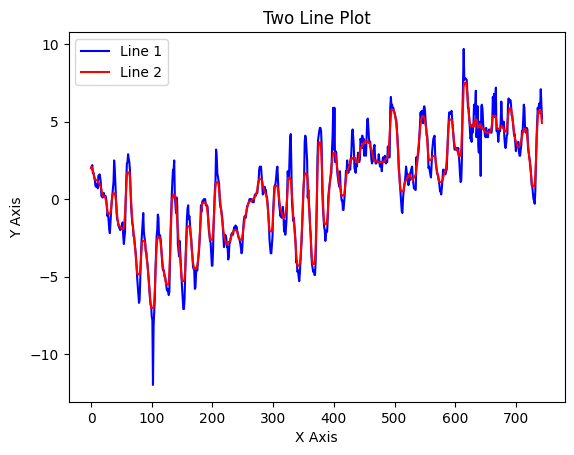

In [90]:
x = range(744)
y1 = df.Cleaned[0:744]
y2 = df.Trimmed[0:744]
plt.plot(x, y1, label='Line 1', color = "blue")
plt.plot(x, y2, label='Line 2', color="red")

# add a legend and labels
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Two Line Plot')


# display the plot
plt.show()

As we can see it worked really well with dealing with outliers (clearly demonstrated at point 100 on the x-axis)

## Statistics
Getting some statistical values from both the cleaned and trimmed column in the dataset

In [45]:
# Minimum and maximum
minimum = df[["Cleaned", "Trimmed"]].min()
maximum = df[["Cleaned", "Trimmed"]].max()

print(f'minimum: \n{minimum}, \n\nMaximum: \n{maximum}')

minimum: 
Cleaned   -19.20
Trimmed   -14.04
dtype: float64, 

Maximum: 
Cleaned    39.60
Trimmed    31.87
dtype: float64


In [46]:
# Mean
mean = df[["Cleaned", "Trimmed"]].mean()

print(f'\nMean: \n{mean}')


Mean: 
Cleaned    9.431147
Trimmed    9.407746
dtype: float64


In [47]:
# Quartiles
q1 = df[["Cleaned", "Trimmed"]].quantile(0.25)
q2 = df[["Cleaned", "Trimmed"]].quantile(0.5)
q3 = df[["Cleaned", "Trimmed"]].quantile(0.75)

print(f'\nQ1: \n{q1}, \n\nQ2: \n{q2}, \n\nQ3: \n{q3}')


Q1: 
Cleaned    4.10
Trimmed    4.12
Name: 0.25, dtype: float64, 

Q2: 
Cleaned    9.10
Trimmed    9.06
Name: 0.5, dtype: float64, 

Q3: 
Cleaned    15.20
Trimmed    15.21
Name: 0.75, dtype: float64


In [48]:
# Standard deviation
standard = df[["Cleaned", "Trimmed"]].std()

print(f'\nStandard deviation: \n{standard}')


Standard deviation: 
Cleaned    6.996330
Trimmed    6.890171
dtype: float64


In [49]:
#Confidence interval
sem = st.sem(df[["Cleaned", "Trimmed"]])
ci = st.t.interval(0.95, len(df[["Cleaned", "Trimmed"]]) - 1, loc=mean, scale=sem)
con_int = {"Cleaned": (ci[0][0], ci[1][0]), "Trimmed": (ci[0][1], ci[1][1])}

print(f'confidence intervals:\nCleaned: {con_int["Cleaned"]}, \n\nTrimmed: {con_int["Trimmed"]}')

confidence intervals:
Cleaned: (9.390530400257589, 9.471764192700888), 

Trimmed: (9.367744902903713, 9.447746099982734)


## Plotting the data

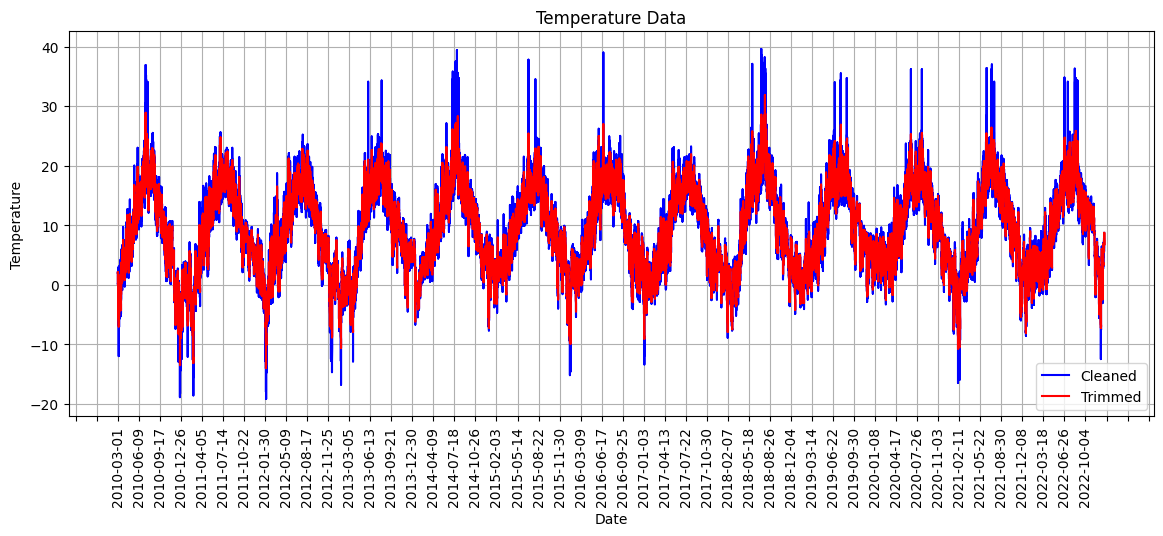

In [50]:
x = df.Datum
y1 = df.Cleaned
y2 = df.Trimmed

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(x, y1, label='Cleaned', color = "blue")
ax.plot(x, y2, label='Trimmed', color="red")

ax.xaxis.set_major_locator(plt.MaxNLocator(52))

# add a legend and labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Data')
ax.grid()
plt.legend()

plt.xticks(rotation=90)

# display the plot
plt.show()


## Coldest months

In [91]:
months_string = ["Januari", "February", "Mars", "April", "May", "June", "July", "August", "September", "Oktober", "November", "December"]
months = []
for year in range(2010, 2024):
    for month in range(1, 13):
        if month < 10:
            month_df = df[df.Datum < f"{year}-0{month + 1}"]
            month_df = month_df[month_df.Datum > f"{year}-0{month}"]
        else:
            month_df = df[df.Datum < f"{year}-{month + 1}"]
            if month == 10:
                month_df = month_df[month_df.Datum > f"{year}-0{month}"]
            else:
                month_df = month_df[month_df.Datum > f"{year}-0{month}"]
        if len(month_df) > 0:
            month_df.reset_index(inplace=True)
            months.append(month_df)

temp_dict = {}
for month in months:
    temp_dict[month["Datum"][0][0:7]] =  month["Trimmed"].mean()  

sorted_temp_dict = dict(sorted(temp_dict.items(), key=lambda item: item[1]))

print("The 10 coldest months are:")

for i in range(10):
    print(f'{list(sorted_temp_dict.keys())[i][:4]}/{months_string[int(list(sorted_temp_dict.keys())[i][-1])-1]}: {list(sorted_temp_dict.values())[i]}')

The 10 coldest months are:
2016/Januari: -0.897340425531915
2013/Mars: -0.8228421052631577
2013/Januari: -0.6326826029216468
2011/Januari: -0.44604497354497347
2018/Mars: -0.007406914893617069
2017/Januari: 0.6992418300653596
2021/Januari: 0.7870928667563931
2019/Januari: 1.0859366754617414
2014/Januari: 1.254144736842105
2012/Januari: 1.5612026143790851


## Finding the distrubution
We start by plotting a histogram of the data to see if the distrubution is clearly visible

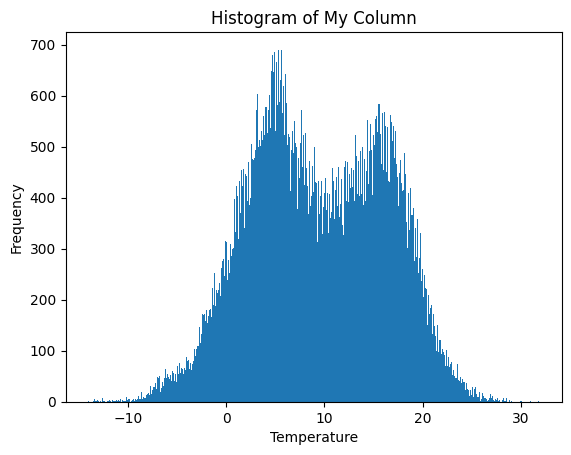

In [52]:
plt.hist(df['Trimmed'], bins=500)

# Add labels and a title to the plot
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of My Column')

# Display the plot
plt.show()

We can see that the data is bimodal (has two peaks). We try to split the two peaks by plotting histograms of different halfs of the year

In [53]:
def transform_int(i):
    if i < 10:
        return "0"+str(i)
    else: return str(i)

def normal_test(df):
    result = anderson(df['Trimmed'], dist='norm')
    if result.statistic > result.critical_values[2]:
        result = False
    else:
        result = True

    return result

In [54]:
from IPython.display import clear_output
import warnings

# Clear the output
values = ""
warnings.simplefilter(action='ignore', category=FutureWarning)


# for start_month in range(1, 13):
#     for start_day in range(1, 31):
#         for end_month in range(1, 13):
#             if abs(start_month - end_month) > 3:
#                 for end_day in range(1, 31):
#                     clear_output(wait=True)
#                     print(f'Start month: {start_month}')
#                     print(f'Start day: {start_day}')
#                     print(f'End month: {end_month}')
#                     print(f'End day: {end_day}')
#                     winter_df = pd.DataFrame()
#                     summer_df = pd.DataFrame()
                
#                     for year in range(2010, 2024):
#                         x = 0
#                         if end_month < start_month:
#                             x = 1
                        
#                         month_df = df[df.Datum >= f"{year - x}-{transform_int(start_month)}-{transform_int(start_day)}"]
#                         month_df = month_df[month_df.Datum <= f"{year}-{transform_int(end_month)}-{transform_int(end_day)}"]
#                         winter_df = winter_df.append(month_df)
                        
#                         month_df = df[df.Datum >= f"{year}-{transform_int(end_month)}-{transform_int(end_day + 1)}"]
#                         month_df = month_df[month_df.Datum <= f"{year + 1 - x}-{transform_int(start_month)}-{transform_int(start_day)}"]
#                         summer_df = summer_df.append(month_df)

#                     winter_normal = False
#                     if len(winter_df) > 0:
#                         if normal_test(winter_df):
#                             winter_normal = True
#                             print(f"winter_normal: {start_day}/{start_month} - {end_day}/{end_month}")

#                     summer_normal = False
#                     if len(summer_df) > 0:
#                         if normal_test(summer_df):
#                             summer_normal = True
#                             print(f"summer_normal: {end_day}/{end_month} - {start_day}/{start_month}")

#                     if winter_normal and summer_normal:
#                         print('Yay!')
#                         values += f"winter_normal and sommer_normal: {start_day}/{start_month} - {end_day}/{end_month}"
#                         break


print(values)

In [55]:
winter_df = pd.DataFrame()
summer_df = pd.DataFrame()

for year in range(2010, 2024):
    month_df = df[df.Datum >= f"{year - 1}-12-01"]
    month_df = month_df[month_df.Datum <= f"{year}-05-15"]
    winter_df = winter_df.append(month_df)

    month_df = df[df.Datum <= f"{year}-11-31"]
    month_df = month_df[month_df.Datum >= f"{year}-05-16"]
    summer_df = summer_df.append(month_df)

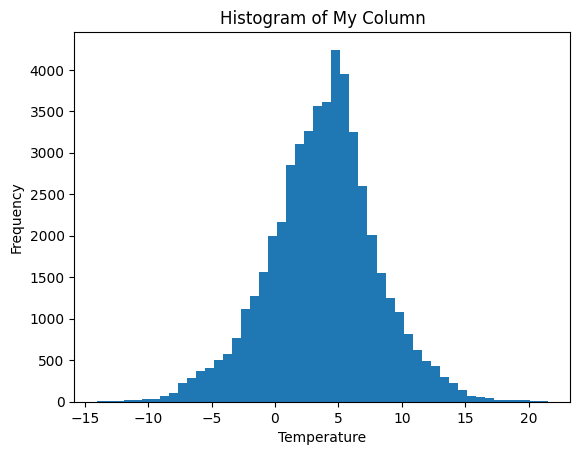

In [56]:
plt.hist(winter_df['Trimmed'], bins=50)

# Add labels and a title to the plot
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of My Column')

# Display the plot
plt.show()

In [57]:
stat, p = shapiro(list(winter_df.Trimmed))

# print the results
print('Test statistic:', stat)
print('p-value:', p)

if p > 0.05:
    print('Data is normally distributed')
else:
    print('Data is not normally distributed')

Test statistic: 0.9949086904525757
p-value: 5.118432993329788e-37
Data is not normally distributed


C:\Users\sebastian.johanss11\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


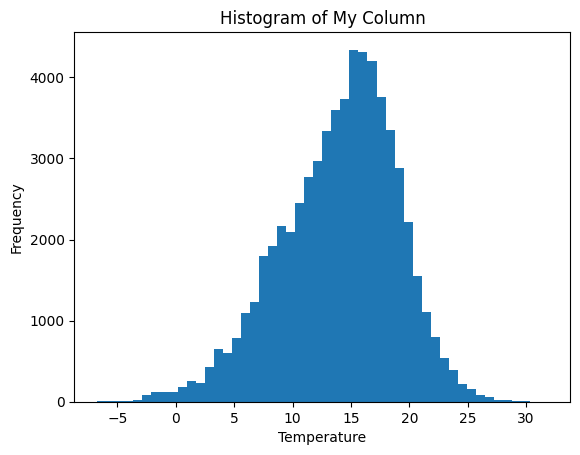

In [58]:
plt.hist(summer_df['Trimmed'], bins=50)

# Add labels and a title to the plot
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of My Column')

# Display the plot
plt.show()

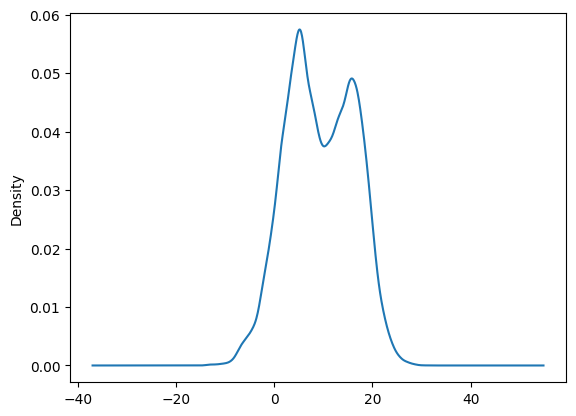

In [59]:
df["Trimmed"].plot.kde()
plt.show()

Following the graphs above we came to the conclution that the distribution is a bimodal distribution.

### Extreme values

In [60]:
Outliers_below = df[["Cleaned"]].quantile(0.001)
Outliers_above = df[["Cleaned"]].quantile(0.999)

print(f'Outliers below: \n{Outliers_below}')
print()
print(f'Outliers above: \n{Outliers_above}')

Outliers below: 
Cleaned   -10.7
Name: 0.001, dtype: float64

Outliers above: 
Cleaned    29.1
Name: 0.999, dtype: float64


We consider values below -10.7 degrees and above 29.1 degrees to be outliers since less than 0.2% of all values are within any of these categories.

In [61]:
outliers = len(df[df.Cleaned > 29.1])
outliers += len(df[df.Cleaned < -10.7])

print(f'Total outliers before data cleaning: {outliers}')

outliers_after = len(df[df.Trimmed > 29.1])
outliers_after += len(df[df.Trimmed < -10.7])

print(f'Total outliers after data cleaning: {outliers_after}')

Total outliers before data cleaning: 224
Total outliers after data cleaning: 72


As we can see above there are 224 of these values in the dataset but after we apply moving average trimmed mean to the dataset, we get rid of about two thirds of all these values

### Average daily mean

First we extract the mean for each day in 2022:

In [62]:
df_2022 = df[df.Datum > '2021-12-31']
df_2022 = df_2022[df_2022.Datum < '2023-01-01']

dates = []
means = []
temp_temps = []

for date, temp in zip(df_2022.Datum, df_2022.Trimmed):
    if date in dates:
        temp_temps.append(temp)
    else:
        if len(temp_temps) > 0:
            means.append(np.mean(temp_temps))
        temp_temps = [temp]
        dates.append(date)
means.append(np.mean(temp_temps))

Then we plot it:

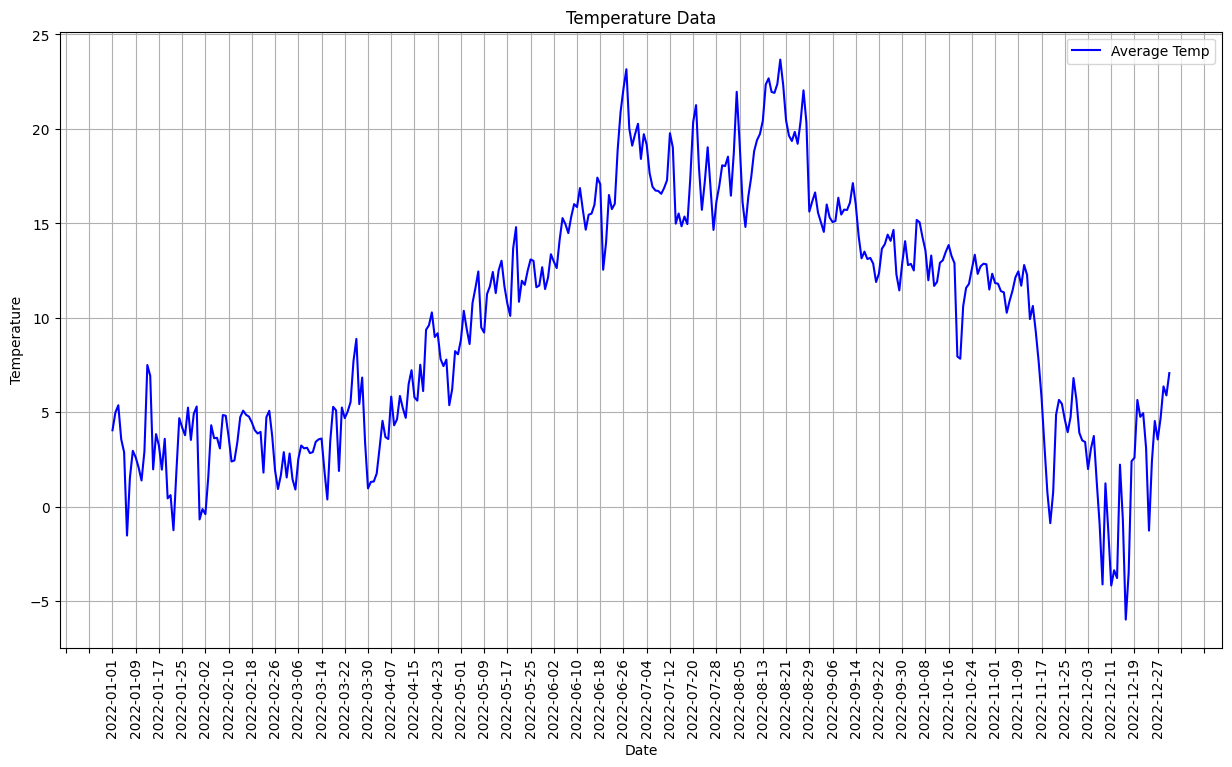

In [63]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(dates, means, label='Average Temp', color = "blue")

ax.xaxis.set_major_locator(plt.MaxNLocator(52))

# add a legend and labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Data')
ax.grid()
plt.legend()

plt.xticks(rotation=90)

# display the plot
plt.show()

### Consecutive months

In [86]:
def get_month(year, month):
    month_df = df[df.Datum < f"{year}-{transform_int(month + 1)}"]
    month_df = month_df[month_df.Datum > f"{year}-{transform_int(month)}"]
    return month_df

y1 = 2010
y2 = 2010
m1 = 2
m2 = 3


month_dict = {}
while y2 != 2023:
    x1 = 0
    x2 = 0

    month = get_month(y1, (m1%12)+1)
    month2 = get_month(y2, (m2%12)+1)
    x1 = month.Trimmed.mean()
    
    x2 = month2.Trimmed.mean()

    x3 = (x2 + x1)/2

    month_dict[str(y1) + "/" + transform_int((m1%12)+1) + " and " + str(y2) + "/" + transform_int((m2%12)+1)] = x3

    m1 += 1
    m2 += 1
    y1 = (m1//12) + 2010
    y2 = (m2//12) + 2010


sorted_temp_dict = dict(sorted(month_dict.items(), key=lambda item: item[1], reverse=True))

for i in range(10):
    print(f'{list(sorted_temp_dict.keys())[i]}: {list(sorted_temp_dict.values())[i]}')



2018/07 and 2018/08: 20.66971784758011
2018/06 and 2018/07: 19.646106997570897
2021/06 and 2021/07: 19.461439550184313
2014/07 and 2014/08: 19.207824853117334
2010/07 and 2010/08: 18.749898653721033
2021/07 and 2021/08: 18.64402708334081
2022/07 and 2022/08: 18.46532633951493
2019/07 and 2019/08: 18.340492589581196
2013/07 and 2013/08: 18.240579259360622
2014/06 and 2014/07: 18.003998287422714


Vad som behöver göras:

    se över om vi hämtar rätt månader i kallaste månader
    se över om 95% mean confidence interval är rätt
    Städa och kommentera histogramen samt göra en qq plot